In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import helpfunction as helper

In [3]:
%autoreload

In [12]:
outdir= './output/FlashHypo/'
inputdir = './input/ImprovedMay/'  
slice_id_name = "pandoraSliceId"

nrPMT = 32
rangePMT = range(nrPMT)

sample_names = ['nue','nu','on','off']
file_names = [next((s for s in os.listdir(inputdir) if "NueCC_"+sample in s), None) for sample in sample_names]
print(file_names)
sample_names_title = dict(zip(sample_names, [r"Intrinsic $\nu_e$", r"BNB $\nu$", r"BNB on (4.4e19)", r"BNB off (data)"]))

['NueCC_nue_run3.root', 'NueCC_nue_run3.root', None, None]


In [6]:
def search_unsorted(index_large, values_large, index_subset):
    if (len(index_large)!=len(values_large)):
        return -1
    sorter = np.argsort(index_large)
    return values_large[sorter][np.searchsorted(index_large[sorter], index_subset)]

In [13]:
file_flashes = {}
file_slices = {}
file_events = {}
for i, (idx, fn) in enumerate(zip(sample_names, file_names)):
    print(fn)
    file_flashes[idx] = uproot.open(inputdir+fn)[slice_id_name+'/flashes']
    file_slices[idx] = uproot.open(inputdir+fn)[slice_id_name+'/slices']
    file_events[idx] = uproot.open(inputdir+fn)[slice_id_name+'/events']
    print(file_events[idx].numentries)

NueCC_nue_run3.root
30
NueCC_nue_run3.root
30
None


TypeError: Can't convert 'NoneType' object to str implicitly

In [16]:
file_events['nue'].keys()

[b'run',
 b'subRun',
 b'event',
 b'evt_time_sec',
 b'evt_time_nsec',
 b'nFlashes',
 b'nFlashesInBeamWindow',
 b'hasBeamFlash',
 b'nSlices',
 b'nSlicesAfterPrecuts',
 b'foundATargetSlice',
 b'targetSliceMethod',
 b'nuInteractionType',
 b'nuCCNC',
 b'nuEnergy',
 b'leptonEnergy',
 b'nuInteractionTime',
 b'nuPdgCode',
 b'nuVertexX',
 b'nuVertexY',
 b'nuVertexZ']

In [10]:
# Flash plots
file_flashes['nu'].keys()

[b'run',
 b'subRun',
 b'event',
 b'evt_time_sec',
 b'evt_time_nsec',
 b'time',
 b'centerY',
 b'centerZ',
 b'widthY',
 b'widthZ',
 b'totalPE',
 b'peSpectrum',
 b'inBeamWindow',
 b'isBrightestInWindow',
 b'isBeamFlash']

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


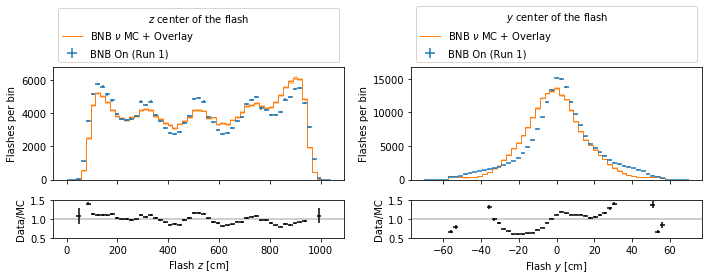

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols=2, sharex='col', figsize=(10,4), gridspec_kw = {'height_ratios':[3, 1]})
axes = [[axes[0][0], axes[1][0]], [axes[0][1], axes[1][1]] ]
fields = ['centerZ', 'centerY']
lab = [r'$z$', r'$y$']
x_min = [0, -70]
x_max = [1040, 70]
N=55

mc_scale = file_flashes['nu'].numentries / file_flashes['on'].numentries
mc_lab = r'BNB $\nu$ MC + Overlay'
data_lab = 'BNB On (Run 1)'


for ax, field, l, xmin, xmax in zip(axes, fields, lab, x_min, x_max):
    masks = [file_flashes['nu'].array('totalPE')>200, file_flashes['on'].array('totalPE')>200]
    data = [file_flashes['nu'].array(field), file_flashes['on'].array(field)]
    edges, edges_mid, bins, err, max_y = helper.histHelper(N, xmin, xmax, data, weights=[1/mc_scale,1])
    ax[0].step(edges_mid, bins[0], lw=1, label=mc_lab, where='mid', color='C1')
    ax[0].fill_between(edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='mid', color='C1')
    ax[0].errorbar(edges_mid, bins[1], yerr=err[1], xerr=edges[:-1]-edges_mid, fmt='none', c='C0', 
                   zorder=3, label=data_lab)
    ax[0].set_ylabel("Flashes per bin")
    ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=l+' center of the flash', loc='lower center', mode='expand')
    ax[0].set_ylim(0, max(max_y)*1.1)

    ratio = bins[1]/(bins[0])
    ratio_err = np.sqrt(1/bins[1]+1/ (bins[0]/mc_scale))*ratio
    ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color='k')

    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel('Flash '+l+' [cm]')
    ax[1].set_ylabel("Data/MC")
    ax[1].set_ylim(0.5,1.5)
    
fig.tight_layout()    
fig.savefig(outdir+"flashxz.pdf")

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:3249: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)


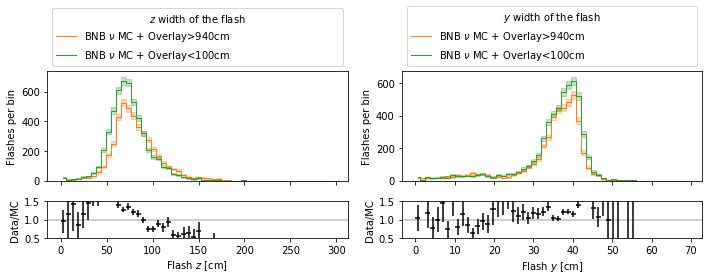

In [12]:
fig, axes = plt.subplots(nrows = 2, ncols=2, sharex='col', figsize=(10,4), gridspec_kw = {'height_ratios':[3, 1]})
axes = [[axes[0][0], axes[1][0]], [axes[0][1], axes[1][1]] ]
fields = ['widthZ', 'widthY']
lab = [r'$z$', r'$y$']
x_min = [0, 0]
x_max = [300, 70]
N=55

mc_scale = file_flashes['nu'].numentries / file_flashes['on'].numentries
mc_lab = r'BNB $\nu$ MC + Overlay'
data_lab = 'BNB On (Run 1)'


for ax, field, l, xmin, xmax in zip(axes, fields, lab, x_min, x_max):
    masks = [file_flashes['nu'].array('centerZ')>940, file_flashes['nu'].array('centerZ')<100]
    data = [file_flashes['nu'].array(field)[masks[0]], file_flashes['nu'].array(field)[masks[1]]]
    edges, edges_mid, bins, err, max_y = helper.histHelper(N, xmin, xmax, data, weights=[1,1])
    ax[0].step(edges_mid, bins[0], lw=1, label=mc_lab+">940cm", where='mid', color='C1')
    ax[0].fill_between(edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='mid', color='C1')
    ax[0].step(edges_mid, bins[1], lw=1, label=mc_lab+"<100cm", where='mid', color='C2')
    ax[0].fill_between(edges_mid, bins[1] - err[1], bins[1] + err[1], alpha=0.3, step='mid', color='C2')
    
    ax[0].set_ylabel("Flashes per bin")
    ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=l+' width of the flash', loc='lower center', mode='expand')
    ax[0].set_ylim(0, max(max_y)*1.1)

    ratio = bins[1]/(bins[0])
    ratio_err = np.sqrt(1/bins[1]+1/ (bins[0]/mc_scale))*ratio
    ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color='k')

    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel('Flash '+l+' [cm]')
    ax[1].set_ylabel("Data/MC")
    ax[1].set_ylim(0.5,1.5)
    
fig.tight_layout()    
fig.savefig(outdir+"flashyz.pdf")

### 2(H-O)/(H+O)-plot

In [13]:
def fillratio(sample, data=True):
    f_flashes = file_flashes[sample]
    f_slices = file_slices[sample]

    flash_ids = f_flashes.array("evt_time_nsec")
    flash_pes = f_flashes.array("peSpectrum")
    
    slice_hypos = f_slices.array("peHypothesisSpectrum")
    slice_flashmatched = (slice_hypos.counts==32) & (slice_hypos.sum()>0.0)
    
    if data:
        slice_selected = f_slices.array("isTaggedAsTarget")
        slice_mask =  slice_flashmatched & slice_selected
    else:
        slice_purity = f_slices.array("purity")>0.8
        slice_completeness = f_slices.array("completeness")>0.8
        slice_mask = slice_purity & slice_completeness & slice_flashmatched
    
    slice_ids = f_slices.array("evt_time_nsec")[slice_mask]
    slice_hypos = np.array(slice_hypos[slice_mask])
    slice_pe = np.array(search_unsorted(flash_ids, flash_pes, slice_ids))

    #pe mask:
    pe_mask = np.sum(slice_pe, axis=1)>200
    slice_hypos=slice_hypos[pe_mask]
    slice_pe=slice_pe[pe_mask]
    
    # 2(H-O)/(H+O)
    a = 2*(slice_hypos-slice_pe)
    b = (slice_hypos+slice_pe)
    y_vals = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    mask = (slice_hypos<1) & (slice_pe<1)
    y_vals[mask]=-3
    
    y = np.nan_to_num(y_vals).T.flatten()
    x = np.repeat(range(32),len(y_vals))
    return x,y

nue
80702.0
nu
106631.0
on
52467.0
off
42853.0


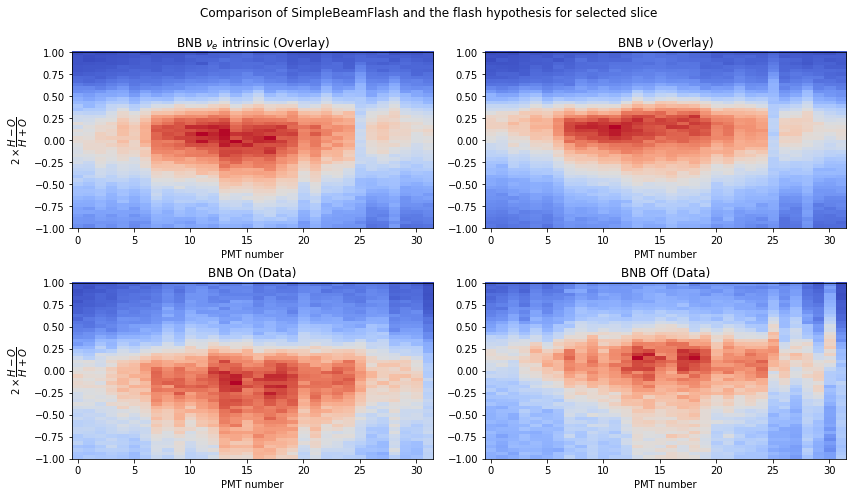

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12,7))
ax=axes.flatten()
sample_titles = [r"BNB $\nu_e$ intrinsic (Overlay)", r"BNB $\nu$ (Overlay)", "BNB On (Data)", "BNB Off (Data)"]

for i,(s,t) in enumerate(zip(sample_names, sample_titles)):
    print(s)
    x,y = fillratio(s)
    print(len(x)/32)
    ax[i].hist2d(x,y, range=((-0.5,31.5),(-1,1)), bins=(32,50), cmap="coolwarm")
    ax[i].set_xlabel(r"PMT number")
    ax[i].set_title(t)
    
ax[0].set_ylabel(r"$2 \times \dfrac{H-O}{H+O}$")
ax[2].set_ylabel(r"$2 \times \dfrac{H-O}{H+O}$")

fig.tight_layout()
fig.suptitle("Comparison of SimpleBeamFlash and the flash hypothesis for selected slice")
fig.subplots_adjust(top=0.89)
fig.savefig(outdir+"hypo_spec.pdf", bbox_inches='tight')

In [13]:
#pmt15 = list(np.nan_to_num(y_vals).T[15])
#plt.hist(pmt15, range=(-4,2))
file_events['nue'].keys()

[b'run',
 b'subRun',
 b'event',
 b'evt_time_sec',
 b'evt_time_nsec',
 b'nFlashes',
 b'nFlashesInBeamWindow',
 b'hasBeamFlash',
 b'nSlices',
 b'nSlicesAfterPrecuts',
 b'foundATargetSlice',
 b'targetSliceMethod',
 b'nuInteractionType',
 b'nuCCNC',
 b'nuEnergy',
 b'leptonEnergy',
 b'nuInteractionTime',
 b'nuPdgCode',
 b'nuVertexX',
 b'nuVertexY',
 b'nuVertexZ']

### Single flash event viewer

In [14]:
df = file_events['nue'].pandas.df()

In [15]:
cols = ['run', 'subRun', 'event', 'nuEnergy']
df.query("targetSliceMethod==2 & nSlices==4")[cols].head(20)

,run,subRun,event,nuEnergy
417,5606,16,831,0.748562
425,5606,17,893,1.457024
809,5208,122,6121,1.465092
1074,6785,203,10167,0.458690
1113,6620,149,7473,1.986978
1389,6790,25,1287,1.348657
1394,6790,26,1320,0.746448
1452,5361,133,6697,0.645148
1495,6544,111,5565,0.643636
1568,6863,76,3820,1.516079


Run 5122 , Subrun 14 , Event 745  found! 
 ------------------------------

--- EVENT INFO ---
nFlashes :	 1
hasBeamFlash :	 True
nSlices :	 4
nSlicesAfterPrecuts :	 2
foundATargetSlice :	 True
nuCCNC :	 0
nuEnergy :	 0.3791459
leptonEnergy :	 0.2044131
nuInteractionTime :	 3630.863
nuPdgCode :	 12
nuVertexX :	 61.386566
nuVertexY :	 -99.783104
nuVertexZ :	 241.83655

--- FLASH INFO ---
time :	 [4.113125]
centerY :	 [-21.65151]
centerZ :	 [242.17336]
widthY :	 [41.05054]
widthZ :	 [110.00574]
totalPE :	 [1096.1149]
inBeamWindow :	 [ True]
isBeamFlash :	 [ True]

--- SLICE INFO ---
hasDeposition :	 [ True  True  True  True]
totalCharge :	 [96109.99  25887.111 25157.625 21097.248]
centerX :	 [245.26059 132.99158  54.35597  49.80951]
centerY :	 [ 99.367485  53.791065 -90.62152  -92.091866]
centerZ :	 [188.23633  344.0029    43.633953 238.13466 ]
minX :	 [238.63467  104.538734   7.842898  31.231222]
nHits :	 [1944  627  547  419]
deltaY :	 [121.019    75.44257 -68.97001 -70.44035]
deltaZ :	

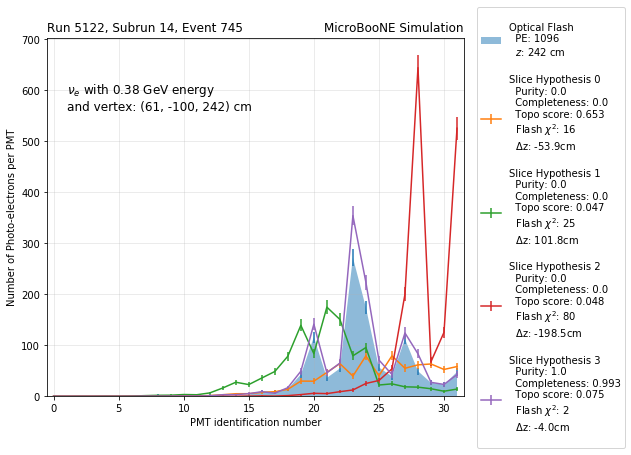

In [16]:
sample = "nue"
run = 5122
subrun = 14
event = 745

sample_dict = {'events': file_events[sample],
               'flashes': file_flashes[sample],
               'slices': file_slices[sample]
              }

helper.SingleEventViewer(run,subrun,event, sample_dict, save_plot=True)

### Plots about the PE per PMT

In [17]:
# Save the PE values of beam flashes in a seperate numpy array:
# For the rolling sample, We only want to compare the PE rates with the run3/4 part
# https://microboone-exp.fnal.gov/at_work/AnalysisTools/data/ub_datasets_optfilter.html

#sample_names = ['nue','nu','on','off']
#file_flashes

#scales = [scale_nue, scale_nu, scale_on, scale_off]
scales = [0.0010569228435649161, 0.45681583509311513, 1, 0.2849382369772876]

df_pe = []
for f,s,w in zip(file_flashes, sample_names,scales):
    mask = file_flashes[s].array("totalPE")>200
    pes = np.array(file_flashes[s].array("peSpectrum")[mask])
    pes = pes.astype(float)
    print(len(pes))
    df = pd.DataFrame(pes)
    df['weight'] = w
    df['sample'] = s
    df_pe.append(df)
df_pe = pd.concat(df_pe)

115366
186476
148555
156761


In [18]:
cols = ["PMT"+str(i) for i in rangePMT]
cols.extend(df_pe.columns[-2:])
df_pe.columns = cols
df_pe.head()

,PMT0,PMT1,PMT2,PMT3,PMT4,PMT5,PMT6,PMT7,PMT8,PMT9,...,PMT24,PMT25,PMT26,PMT27,PMT28,PMT29,PMT30,PMT31,weight,sample
0,2.020979,1.894072,1.279970,0.000000,2.249934,2.694625,9.864773,12.710460,22.739407,30.238228,...,277.094208,51.797344,58.892124,52.405090,49.604458,34.783348,25.355288,32.527138,0.001057,nue
1,0.000000,0.000000,0.000000,0.158368,0.000000,0.221029,0.000000,10.240645,0.934493,10.613071,...,0.872815,0.382380,0.160036,0.000000,0.000000,0.000000,0.000000,0.000000,0.001057,nue
2,82.589722,63.718601,99.774849,65.407791,123.032745,86.418770,134.395157,107.374374,90.513161,67.518082,...,1.428355,0.000000,0.000000,0.000000,4.382387,0.000000,4.640227,0.000000,0.001057,nue
3,0.000000,0.000000,0.000000,2.974735,0.000000,0.000000,0.000000,3.840727,1.129796,0.000000,...,18.463240,6.112481,4.695974,3.070117,6.232707,2.278106,0.000000,0.000000,0.001057,nue
4,11.622165,15.954016,19.096342,18.430845,28.925596,18.991636,34.381496,43.695679,38.907318,42.981419,...,0.000000,0.000000,0.000000,0.000000,4.274221,0.000000,0.000000,0.000000,0.001057,nue


In [19]:
means = df_pe.groupby(['sample']).mean()
print(means)

             PMT0       PMT1       PMT2       PMT3       PMT4       PMT5  \
sample                                                                     
nu      53.176872  50.576285  51.721310  57.387335  59.987021  51.058991   
nue     77.940292  83.130147  76.851354  85.722302  89.533299  60.722038   
off     44.059131  47.980310  36.386414  52.927758  56.221429  55.347103   
on      44.571441  49.010730  37.733348  53.841096  57.123202  56.188821   

             PMT6        PMT7       PMT8       PMT9    ...         PMT23  \
sample                                                 ...                 
nu      62.716573   71.011446  61.333700  65.345224    ...     56.897461   
nue     72.159532  112.013548  75.910528  99.043976    ...     68.791228   
off     51.668026   62.793002  49.434053  66.110889    ...     55.305371   
on      51.452823   65.361230  50.642027  67.808129    ...     57.535294   

            PMT24      PMT25      PMT26      PMT27      PMT28      PMT29  \
sample    

In [20]:
df = means.transpose()
df.drop(df.tail(1).index,inplace=True)

Text(0,0.5,'Photo-electrons')

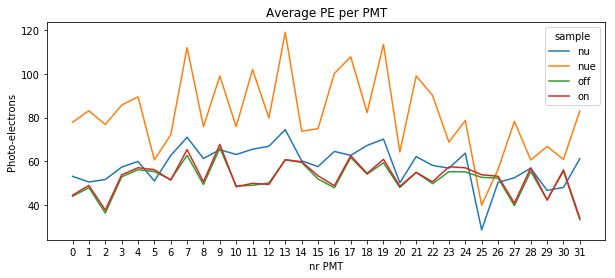

In [21]:
ax = df.plot(title='Average PE per PMT', xticks=rangePMT, figsize=(10,4))
ax.set_xticklabels(rangePMT)
ax.set_xlabel("nr PMT")
ax.set_ylabel("Photo-electrons")